# **GIN?**

**Generalized Inverted Index.**


- 인덱싱할 항목이 합성된 값이고 인덱스가 처리할 쿼리는 합성된 항목 내에 나타나는 요소 값을 검색해야 하는 경우를 처리하기 위해 설계됨(아이템은 문서일 수 있고, 쿼리는 특정 단어가 포함된 문서를 검색하는 것일 수 있음)
- 항목(item)은 인덱싱할 합성값을 나타낼 때 사용하고, 키(key)는 요소 값을 나타낼 때 사용함
- GIN은 항상 항목 값이 아닌 키를 저장하고 검색함
- GIN 인덱스는 일련의 (키, posting list(key가 발생하는 row id set임)) 쌍을 저장함
- 항목에 둘 이상의 키가 포함될 수 있으므로 동일한 행 ID가 여러 posting list에 나타날 수 있음
- 각 키 값은 한 번만 저장되므로 동일한 키가 여러 번 나타나는 경우 GIN 인덱스는 매우 경량화될 수 있음
- GIN은 GIN 액세스 방식 코드가 가속하는 특정 연산을 알 필요가 없다는 점에서 일반화되지만, 특정 데이터 유형에 대해 정의된 맞춤형 전략을 사용함(이 전략은 인덱스된 항목 및 쿼리 조건에서 키를 추출하는 방법과 쿼리에 일부 키 값이 포함된 행이 실제로 쿼리를 충족하는지 여부를 결정하는 방법을 정의함)
- GIN은 데이터베이스 전문가가 아닌 데이터 유형 분야의 전문가가 적절한 접근 방식으로 맞춤형 데이터 유형을 개발할 수 있음(GiST를 사용하는 것과 비슷한 장점을 취함)


**내장된 연산자 클래스**

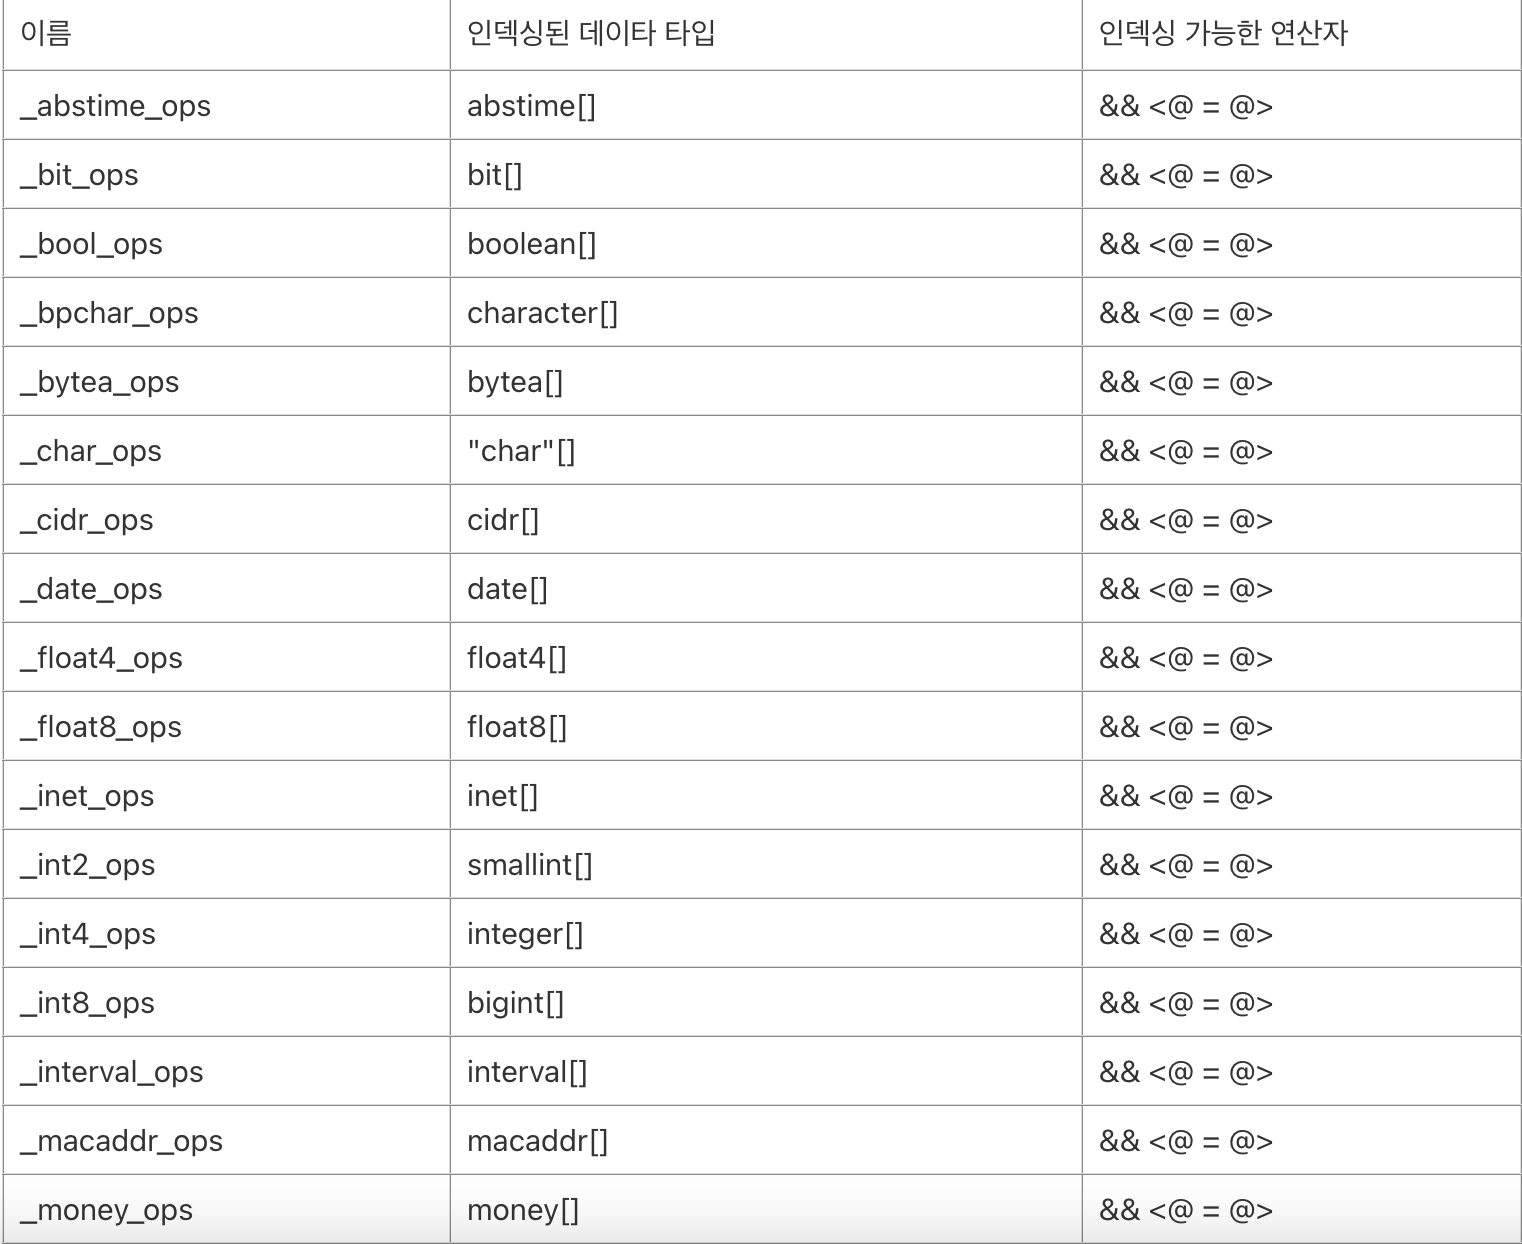
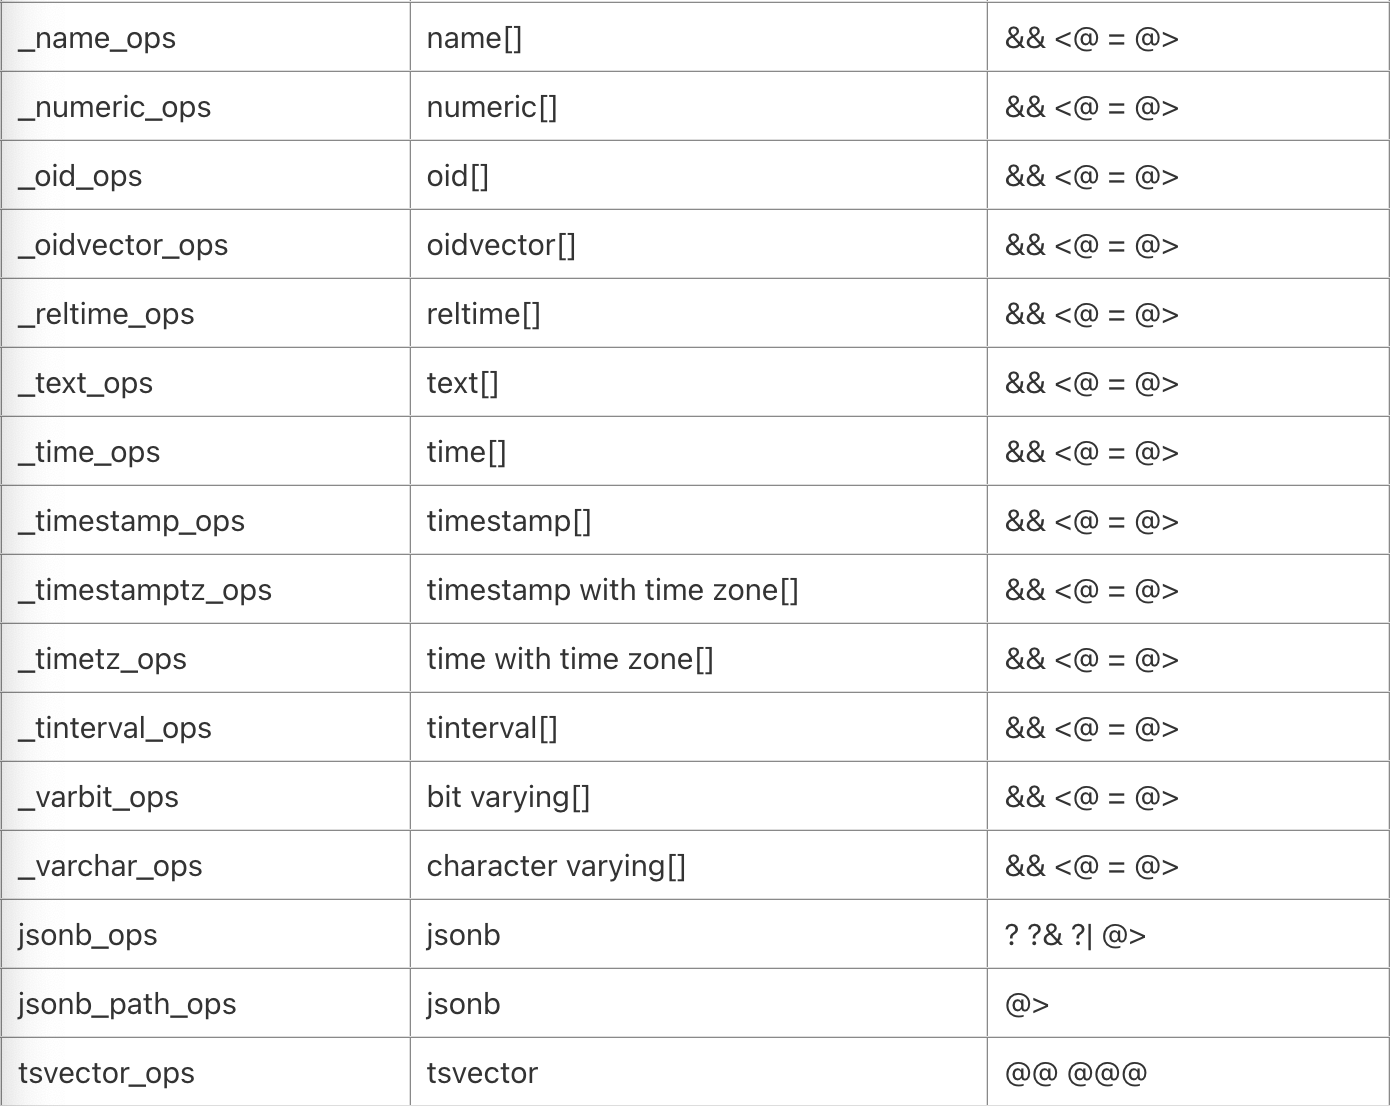

* 두 연산자 클래스의 타입은 jsonb, jsonb_ops가 기본.
* json_path_opts는 소수의 연산자에 대해 지원하지만 이런 연산자에 대해 더 나은 성능을 제공함

**확장성**

- GIN 계층 자체는 동시성, 로그 기록, tree 구조 검색을 담당함 -> 높은 수준의 추상화를 지니고 있어 접근 방법 구현자가 접근 중인 data 유형의 의미만 구현하면 됨
- GIN access method가 돌아가려면 tree에서 key의 동작 및 키/index항목, index 가능한 쿼리간의 관계를 정의하는 몇 가지 사용자 정의 method를 구현하면 됨

<br>

**GIN이 제공하는 주요 method**

<br>

1. int compare(Datum a, Datum b)
 - 인덱싱 되지 않은 두 키를 비교하고(첫 번째 key가 두 번째 key보다 큰지/작은지 비교) 0보다 큰 integer를 반환
 - Null은 반환되지 않음

<br>

2. Datum \*extractValue(Datum itemValue, ind32 \*nKeys, bool \**nullFlags)
 - 인덱싱 된 key의 palloc'd array를 반환
 - 반환되는 key는 \*nkeys에 저장되어 있어야 함
 - 어떤 key든 null일 수 있다면, *nkeys bool 필드 배열도 palloc하고 *nullFlags에 주소를 저장한 후 필요에 따라 null 플래그를 설정함
 - \*nullFlags는 모든 키가 null이 아닌 경우 NULL(초기 값)로 남겨둘 수 있음
 - 항목에 키가 없는 경우 반환 값은 NULL일 수 있음

<br>

3. Datum \*extractQuery(Datum query, int32 \*nkeys, StrategyNumber n, bool \**pmatch, Pointer \**extra_data, bool \**nullFlags, int32 \*searchMode)
 - 쿼리할 값(indexing 가능한 연산자의 우측에 있는 값. 좌측은 indexing된 row)이 지정된 key의 palloc'd array를 반환
 - n은 연산자 클래스를 포함한 전략 번호임
 - extractQuery는 쿼리의 데이터 타입과 key 값을 추출할 때 사용되는 method를 정하려 할 때 n을 자주 참조함
 - return key는 \*nkeys에 저장되어야 함. key가 null인 가능성이 있을 경우, \*nkeys의 bool field 배열도 palloc하고 \*nullFlags에 address를 저장 후 필요에 따라 null flag를 설정함
 - 항목에 키가 없는 경우 반환 값은 NULL일 수 있음
 - \*searchMode는 추출을 허용하는 출력 인수로, 검색 방법에 대한 세부 정보를 지정하는 쿼리임
 - \*searchMode가 GIN_SEARCH_MODE_DEFAULT(호출 전에 초기화되는 값)로 설정된 경우 반환된 키 중 하나 이상과 일치하는 항목만 후보 일치로 간주됨
 - \*searchMode가 GIN_SEARCH_MODE_INCULD_EMPETY로 설정된 경우 일치하는 키가 하나 이상 포함된 항목 외에도 키가 전혀 없는 항목이 후보 일치로 간주됨(이 mode는 is-sub-set of 연산자를 구현하는 데 유용함)
 - \*searchMode가 GIN_SEARCH_MODE_ALL로 설정된 경우 인덱스의 null이 아닌 모든 항목이 반환된 키와 일치하는지 여부에 관계없이 후보 항목으로 간주함(이 mode는 기본적으로 전체 인덱스를 검색해야 하므로 다른 두 옵션보다 훨씬 느리지만 코너 케이스를 올바르게 구현해야 할 수 있음). (그러나 대부분의 경우 이 모드가 필요한 연산자는 GIN 연산자 클래스에 적합하지 않을 수 있음) 이 모드를 설정하는 데 사용할 기호는 access/gin.h에 정의되어 있음
 - \**pmatch는 부분적 match를 지원할 경우 사용하는 출력 인수임
 - \**pmatch를 사용하려면 extractQuery가 *nkeys bool array를 할당하고 해당 주소를 \*pmatch에 저장해야 함
 - 해당 키에 부분 일치가 필요한 경우 배열의 각 요소를 TRUE로 설정하고 그렇지 않은 경우 FALSE로 설정해야 함
 - \*pmatch가 NULL로 설정되면 GIN은 부분 일치가 필요하지 않다고 가정함
 - 변수는 호출 전에 NULL로 초기화되므로 부분 일치를 지원하지 않는 연산자 클래스에서는 이 인수를 무시할 수 있음
 - \**extra_data 는 extractQuery가 일관성 및 comparePartial method에 추가 data를 전달할 수 있도록 하는 출력 인수임
 - \**extra_data를 사용하려면, extraQuery는 *nkeys의 포인터의 배열에 할당해야 하고, *extra_data의 주소를 포인터에 저장한 후, 원하는 대로 개별 포인터에 저장해야 함
 - 변수는 호출 전 null로 초기화되므로, 추가 데이터가 필요치 않은 연산자 클래스가 무시할 수 있음
 - \**extra_data가 세팅되면, 전체 array가 일관된 method로 통과하고, 적당한 요소가 comparePartial method로 전달됨

- 연산자 클래스는 인덱스된 아이템이 query에 match되었을 경우 이를 체크하기 위한 function을 제공해야 하는데, 이 때 쓰이는 것이 boolean consistent function(부울 일관성 함수)와 triConsistent function(삼원 일치 함수)임

- 삼원 일치 함수는 두 가지 모두를 포함하기 때문에 삼원 일치 함수만 사용해도 되지만, boolean 변형이 계산 할 때 저렴할 경우 이를 사용하는 게 나을 수 있음
- boolean 변형만 사용할 경우 모든 키를 가져오기 전에 index item을 새로 지정해야 하는 일부 최적화가 비활성화 됨

1. bool consistent(bool check[], StrategyNumber n, Datum query, int32 nkeys, Pointer extra_data[], bool \*recheck, Datum queryKeys[], bool nullFlags[])
 - 인덱싱 된 항목이 전략적 번호 n(또는 재점검 표시가 반환되는 경우도 이 규칙을 따름)을 만족할 경우 TRUE를 반환함
 - 이 함수는 GIN이 특정 항목을 명시적으로 지정하지 않기 때문에 인덱싱 된 항목에 직접 접근할 수 없음. 단, 쿼리에서 추출된 key value가 지정된, indexing 된 항목에 표시되는 정보를 알 수 있음
 - check array의 length는 이 쿼리 data에 대해 extractQuery에서 이전에 반환한 키 수와 동일한 nkey임
 - 인덱스된 아이템 안에 해당 쿼리가 포함된 경우(if (check[i] == TRUE) extraQuery의 결과 배열의 i번째 key가 현재 인덱스 된 항목에 존재할 경우) 검사 배열의 각 요소는 TRUE임
 - 일관적인 method가 참조해야 할 경우 원래 쿼리 데이터가 전달되고, 과거에 extractQuery에 의해 반환된 queryKeys[]와 nullFlags[] 배열 또한 마찬가지로 원래 쿼리 데이터가 전달됨. extra_data는 extraQuery에 의해 extra-data 배열이 리턴됨(아무것도 없으면 null 반환)
 - extraQuery가 queryKeys[]에서 null key를 반환할 때, 인덱스 된 항목이 null key를 포함할 경우, 해당 check[] element는 TRUE임. 즉, check[]의 의미는 'IS NOT DISTINCT FROM'과 같음
 - 일관된 함수는 일반 값의 일치 및 null 일치간의 차이를 알려야 할 때 해당 nullFlags[] 요소를 검사할 수 있음
 - 성공 시, heap 튜플이 쿼리 연산자에 대해 재확인이 필요할 경우 TRUE로 설정해야 하고, 테스트가 정확할 경우에는 FALSE를 세팅해야 함. 즉, FALSE 반환 값은 heap 튜플이 쿼와 매치되지 않을 경우를 보장하고, \*recheck가 FALSE로 설정된 TRUE 리턴값은 heap tuple과 일치함을 뜻함
 - \*recheck가 TRUE로 설정된 TRUE 반환값은 heap 튜플이 쿼리와 일치할 수 있음을 의미하므로, 원래 인덱싱 된 항목에 대해 쿼리 연산자를 직접 평가하여 다시 가져와 확인함
2. GinTernaryValue triConsistent(GinTernaryValue check[], StrategyNumber n, Datum query, int32 nkeys, Pointer extra_data[], Datum queryKeys[], bool nullFlags[])
 - triconsistent는 consistent와 유사하지만 GIN_TRUE, GIN_FALSE, GIN_MAYBE가 boolean check[]를 대신할 수 있음
 - GIN_FALSE와 GIN_TRUE는 일반적인 boolean 값과 같음
 - GIN_MAYBE는 key를 모를 경우 사용됨
 - GIN_MAYBE가 존재할 경우, 함수는 항목이 해당 쿼리를 포함할 때 값 여부를 판단하여 존재할 경우 GIN_TRUE를 리턴
 - 해당 값이 존재하지 않을 때,  GIN_FALSE를 리턴(GIN_MAYBE를 포함하든 하지 않든)함
 - GINI_MAYBE 항목에 따라 결과가 달라질 경우(match가 제대로 작성되지 않거나, 알려진 쿼리키에 의거하여 일치여부를 확인할 경우) 함수는 반드시 GIN_MAYBE를 반환함

선택적으로, GIN을 위한 연산자 클래스로 다음 method를 제공함

-> int comparePartial(Datum partial_key, Datum key, StrategyNumber n, Pointer extra_data)
 - 부분적으로 일치하는 쿼리 key와 인덱스 key를 비교함. 결과값은 integer 형태임
 - 0보다 작은 값을 반환할 경우 인덱스 key는 더이상 쿼리와 일치하지 않음을 뜻하나, 인덱스 스캔은 계속되어야 함
 - 0을 반환할 경우 인덱스 key는 더이상 쿼리와 일치하지 않음을 뜻함
 - 0보다 큰 값을 반환할 경우 더이상 가능한 게 일치하지 않을 것이므로 인덱스 스캔은 중단됨
 - 검색 종료 시기를 결정하기 위한 의미론이 필요한 경우 전략적 번호 n을 부분 일치 쿼리가 제공해줌
 - extra-data 배열은 extracQuery에 의해 만들어지고, 값이 없을 경우 null을 반환함
 - null key는 이 함수에 전해질 수 없음

부분 일치 쿼리를 제공하기 위해서, 연산자 클래스는 comparePartial 메소드를 제공해야 하며, extractQuery 메소드는 부분 일치 쿼리가 발생할 경우 pmatch parameter를 세팅해야 함

위에 열거된 다양한 Datum 값의 실제 데이터 타입은 연산자 클래스에 따라 다름

extractQuery, Consistent 및 triConsistent에 전달된 쿼리 인수의 유형은 전략 번호로 식별되는 클래스 멤버 연산자의 오른쪽 입력 유형으로 지정된 모든 것들을 포함함. 즉, 올바른 유형의 키 값을 추출할 수 있는 한 항목 유형과 같을 필요는 없음

# **GIN Tips**

Create vs insert
 - GIN 인덱스에 삽입하는 건 각 항목에 대해 많은 키들이 삽입될 가능성이 있어 느릴 수 있음. 그러므로, 테이블에 bulk insertion(대량 삽입)할 경우 이 과정을 완료한 후 GIN 인덱스를 다시 생성하는 게 나음
 - PostgreSQL 8.4에서는 지연 인덱싱이 사용되어 위 과정의 필요성이 적지만, 대규모 업데이트의 경우에는 인덱스 삭제 후에 다시 생성하는 게 나음

maintenance_work_mem
 - GIN 인덱스 빌드 타임은 maintenance_work_mem 세팅에 매우 민감함
 - 인덱스 생성 중에 작업 메모리를 절약하는 건 비용이 들지 않음

gin_pending_list_limit
 - 존재하는 GIN 인덱스에 fastupdate가 활성화 되었을 때 insert를 수행할 동안 시스템은 gin_pending_list_limit보다 항목이 커질 경우 시스템은 보류 중인 entry list를 정리함. 이로 인한 응답 시간의 변화를 피하려면 보류 목록 정리를 백그라운드에서 수행하게끔 하면 좋음. 이 과정은 gin_pending_list_limit를 늘리거나 autovacuum을 더 적극적으로 설정하여 foreground cleanup을 방지할 수 있음
 - 그러나 이렇게 늘린다는 건 coreground cleanup의 시간이 더 걸릴 수 있음
 - 스토리지 매개 변수를 변경하여 개별 GIN 인덱스에 대해 gin_pending_list_limint를 재정의할 수 있음. 이를 통해 각 GIN 인덱스는 자체 cleanup 임계값을 가질 수 있음(업데이트가 많은 GIN 인덱스에 대해서만 임계값을 높이고, 그렇지 않은 경우 줄일 수 있음)

gin_fuzzy_search_limit
 - GIN 인덱스의 개발 주요 목표는 PostgreSQL에서 확장성이 높은 full-text를 지원하는 것이었고, full-text 검색 결과가 너무 많은 결과 set을 반환하는 경우가 많았음. 더 나아가, 쿼리에 매우 빈번한 단어가 존재하여 큰 결과 집합이 유용하지 않을 경우 자주 발생하였음. 디스크에서 많은 튜플들을 읽어와 정렬하는 데에는 많은 시간이 소요되었고, 이는 용납되지 않는 행위임
 - 이러한 쿼리 실행을 제어하기 위해서, GIN은 gin_fuzzy_search 라는 구성 파라미터를 사용하여 반환되는 행 수에 대해 구성 가능한 soft 상한을 제어함. 기본 0으로 설정되고, 0이 아닌 값이 설정될 경우, 랜덤하게 설정된 전체 결과 집함의 하위 집합이 반환됨
 - "Soft" 는 쿼리 및 시스템의 난수 생성기 성능에 따라 반환된 결과의 실제 수가 지정된 제한과 다소 다를 수 있음을 의미함(수천 단위의 값이(5000 - 20000) 잘 작동함)


**제한**

- GIN은 인덱싱 가능한 연산자가 엄격하다고 추정함.
 - 이는 곧 extractValue는 null 아이템 값을 호출하지 못함을 의미하며(대신에 placeholder index 항목이 자동으로 호출됨), extractQuery는 null 쿼리 또한 호출하지 못함(대신, 쿼리는 조건을 충족하지 못한 것으로 가정함).
 - null key값은 non-null 복합 아이템 혹은 쿼리 값은 지원함


예제
PostgreSQL 소스 배포는 vsvector와 모든 내장 타입의 일차원 배열에 대한 GIN 연산 클래스를 포함함. tsvector의 접두 검색은 GIN 부분 일치 기능을 사용하여 구현됨

1. btree_gin
 - 다양한 데이터 타입에 대한 B-tree 동적 기능

2. hstore
 - stroing(key, value) 짝에 대한 모듈

3. inarray
 - 향상된 int[] 지원

4. pg_trgm
 - trigram matching을 사용한 텍스트 유사도
            


```sql
         
  window.ReactionButtonType = 'reaction';
window.ReactionApiUrl = '//halkrine.tistory.com/reaction';
window.ReactionReqBody = {
    entryId: 74
}
```
